In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

conf_key = {'CHI':1163450153, 'CSCW':1195049314, 'UBI':1171345118, 'UIST':1166315290}

ori_paperyear_conf = {}
ori_citingpatent_conf = {}

In [2]:
# join paperid with paperyear and papercitation2science
df_year = pd.read_csv('../data/paperyear_result.tsv', usecols=[1,2])
df_paperid = pd.read_csv('../data/HCI_paperids.tsv', sep='\t')
df_paper_year = df_year.merge(df_paperid)

df_papercitation2science = pd.read_csv('../data/papercitationscience_result.tsv', usecols=[3,4])
df_paper_pc2s = df_papercitation2science.merge(df_paperid)

for conf_name,conf_id in conf_key.items():
    ori_paperyear_conf[conf_name] = df_paper_year.loc[df_paper_year['confid']==conf_id]
    ori_citingpatent_conf[conf_name] = df_paper_pc2s.loc[df_paper_pc2s['confid']==conf_id]

ori_citingpatent_conf['CHI'].head(5)

paperid    patent      confid
0  2134161165  10001804  1163450153
1  2134161165   6024576  1163450153
2  2134161165   6028593  1163450153
3  2134161165   6057828  1163450153
4  2134161165   6078308  1163450153

In [3]:
paperyear_map_conf = {}
inv_paperyear_map_conf = {}
for conf, df in ori_paperyear_conf.items():
    paperyear_map = {}
    inv_paperyear_map = {}
    for row in df.iterrows():
        paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1] # paperid
        paperyear = str(row[1]).split(',')[0].split('\n')[1].split()[1] # paperyear 
        if paperyear not in paperyear_map.keys():
            paperyear_map[paperyear] = []    
        if paperid not in paperyear_map[paperyear]:
            paperyear_map[paperyear].append(paperid)
        inv_paperyear_map[paperid] = paperyear
    paperyear_map_conf[conf] = paperyear_map
    inv_paperyear_map_conf[conf] = inv_paperyear_map
print(">>> done paper year map construction")

>>> done paper year map construction


In [4]:
citingpatent_map_conf = {}
citedpaper_map_conf = {}
for conf, df in ori_citingpatent_conf.items():
    citingpatent_map = {}
    citedpaper_map = {}
    inv_paperyear_map = inv_paperyear_map_conf[conf]
    for row in df.iterrows():
        paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1] # paperid
        patentid = str(row[1]).split(',')[0].split('\n')[1].split()[1] # patentid
        # paperyear
        paperyear = inv_paperyear_map[paperid]
        if paperyear not in citingpatent_map.keys():
            citingpatent_map[paperyear] = []
        if paperyear not in citedpaper_map.keys():
            citedpaper_map[paperyear] = []  
        citingpatent_map[paperyear].append(patentid)
        # unique cited paper this year
        if paperid not in citedpaper_map[paperyear]:
            citedpaper_map[paperyear].append(paperid)
    citingpatent_map_conf[conf] = citingpatent_map
    citedpaper_map_conf[conf] = citedpaper_map
print(">>> done citing data")

>>> done citing data


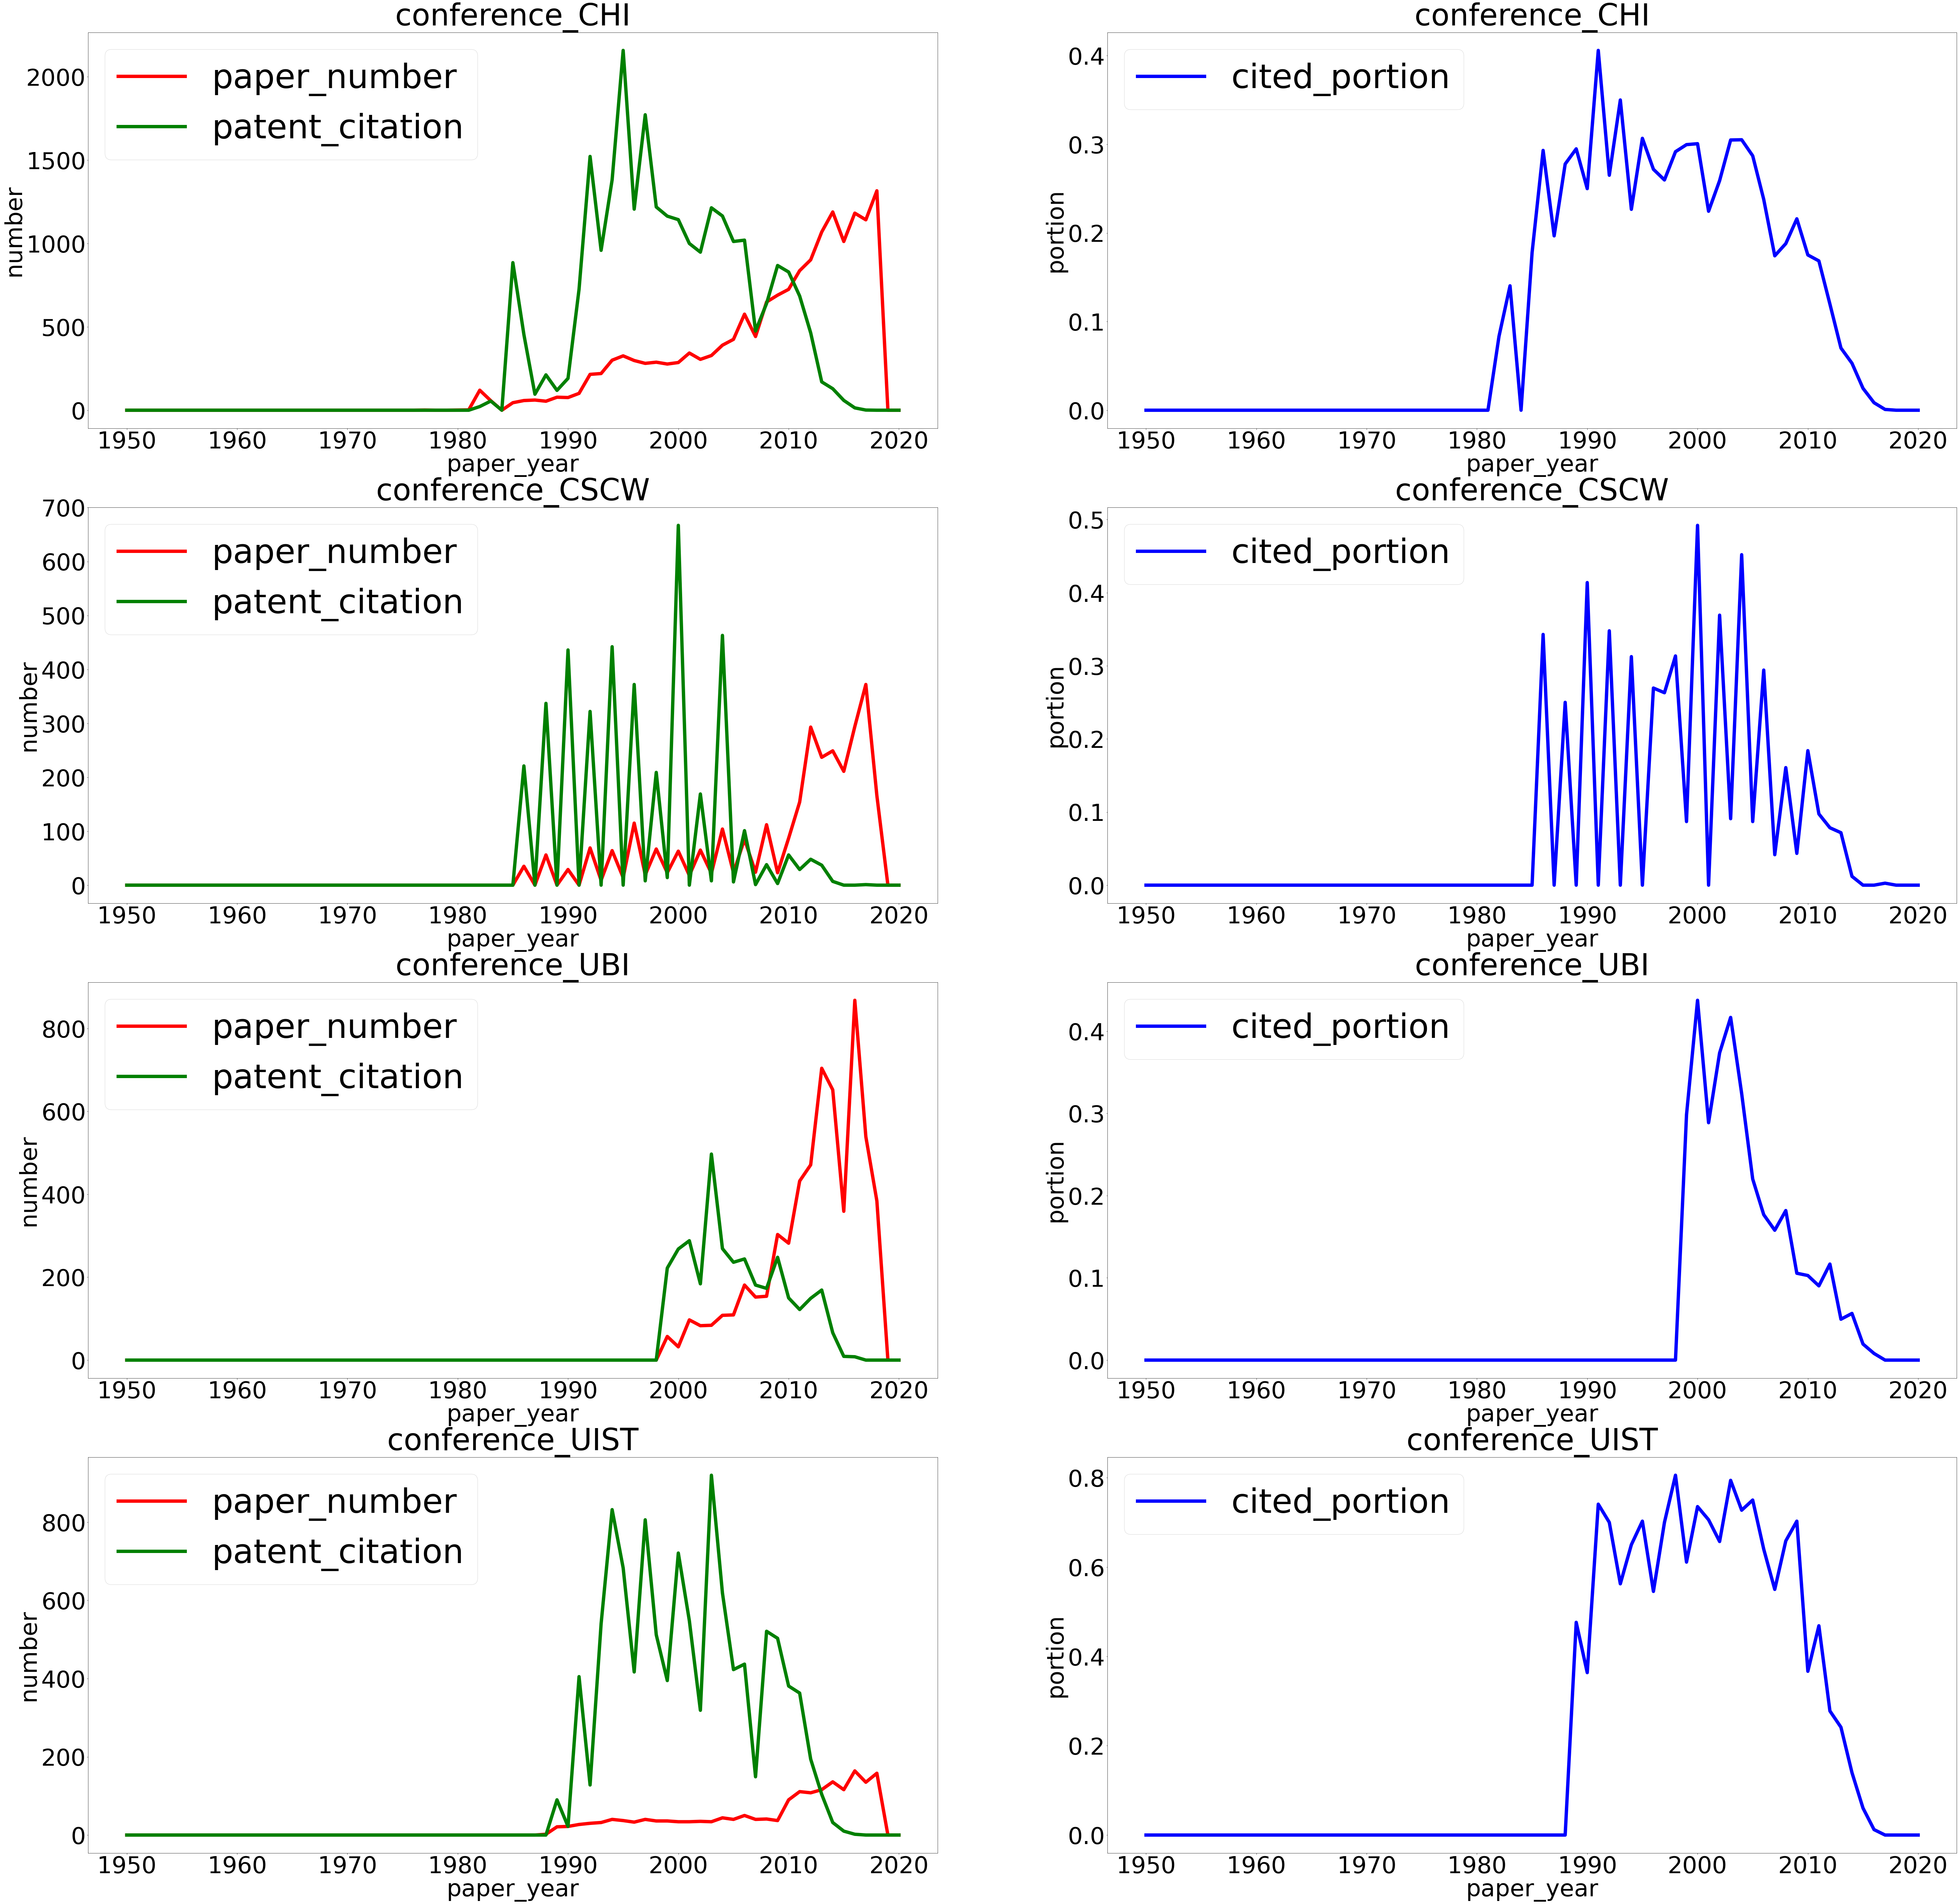

In [16]:
# Visualization
fig = plt.figure(figsize=(100,100))
axes = fig.subplots(nrows=4, ncols=2)
for ax in axes:
    ax[0].set_ylabel("number", fontsize=70)
    ax[1].set_ylabel("portion", fontsize=70)
    for ax_c in ax:
        ax_c.set_xlabel("paper_year", fontsize=70)
        ax_c.tick_params(labelsize=70)

plot_idx = 0

X_year = [i for i in range (1950, 2021)]

for conf, paperyear_map in paperyear_map_conf.items():
    Y_papercnt = [0] * 71
    Y_citingpatentcnt = [0] * 71
    Y_citedportion = [0.0] * 71

    citingpatent_map = citingpatent_map_conf[conf]
    citedpaper_map = citedpaper_map_conf[conf]
    for i in range (1950, 2021):
        if str(i) in paperyear_map.keys():
            Y_papercnt[i-1950] = len(paperyear_map[str(i)])
        if str(i) in citingpatent_map.keys():
            Y_citingpatentcnt[i-1950] = len(citingpatent_map[str(i)])    
        if str(i) in citedpaper_map.keys():
            Y_citedportion[i-1950] = len(citedpaper_map[str(i)]) / Y_papercnt[i-1950]
    axes[plot_idx, 0].plot(X_year,Y_papercnt, 'o-', label='paper_number', color='r', linewidth = 10)
    axes[plot_idx, 0].plot(X_year,Y_citingpatentcnt, 'o-', label='patent_citation', color='g', linewidth = 10)
    axes[plot_idx, 0].set_title('conference_{}'.format(conf), fontsize=90)
    axes[plot_idx, 0].legend(loc = 'upper left', prop={'size': 100})
    axes[plot_idx, 1].plot(X_year,Y_citedportion, 'o-', label='cited_portion', color='b', linewidth = 10 )
    axes[plot_idx, 1].set_title('conference_{}'.format(conf), fontsize=90)
    axes[plot_idx, 1].legend(loc = 'upper left', prop={'size': 100})
    plot_idx += 1
# plt.legend(loc = 'upper left')

In [17]:
#------------ analyze paper author -------------#
ori_author_conf = {}
# author
df_author = pd.read_csv('../data/paperauthororder.tsv', usecols=[1,2])
df_paper_author = df_author.merge(df_paperid)
for conf_name,conf_id in conf_key.items():
    ori_author_conf[conf_name] = df_paper_author.loc[df_paper_author['confid']==conf_id]
ori_author_conf['CHI'].head(5)

paperid    authorid      confid
0  1001944803  1925449899  1163450153
1  1001944803  2073417960  1163450153
2  1001944803  2113201779  1163450153
3  1001944803  2141153954  1163450153
4  1001944803  2153250100  1163450153

In [18]:
citedpaper_list_conf = {}
for conf, df in ori_citingpatent_conf.items():
    citedpaper_list = []
    for row in df.iterrows():
        paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1] # paperid
        # patentid = str(row[1]).split(',')[0].split('\n')[1].split()[1] # patentid
        citedpaper_list.append(paperid)
    citedpaper_list_conf[conf] = citedpaper_list

cited_author_map_conf = {}
notcited_author_map_conf = {}
for conf, df in ori_author_conf.items():
    inv_paperyear_map = inv_paperyear_map_conf[conf]
    cited_author_map = {}
    notcited_author_map = {}
    cited_paper_list = citedpaper_list_conf[conf]
    for row in df.iterrows():
        paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1]
        authorid = str(row[1]).split(',')[0].split('\n')[1].split()[1]
        paperyear = inv_paperyear_map[paperid]
        if paperid in cited_paper_list:
            if paperyear not in cited_author_map.keys():
                cited_author_map[paperyear] = []
            if authorid not in cited_author_map[paperyear]:
                cited_author_map[paperyear].append(authorid)
        else:
            if paperyear not in notcited_author_map.keys():
                notcited_author_map[paperyear] = []
            if authorid not in notcited_author_map[paperyear]:
                notcited_author_map[paperyear].append(authorid)
    cited_author_map_conf[conf] = cited_author_map
    notcited_author_map_conf[conf] = notcited_author_map
print(">>> author map construction done")

>>> author map construction done


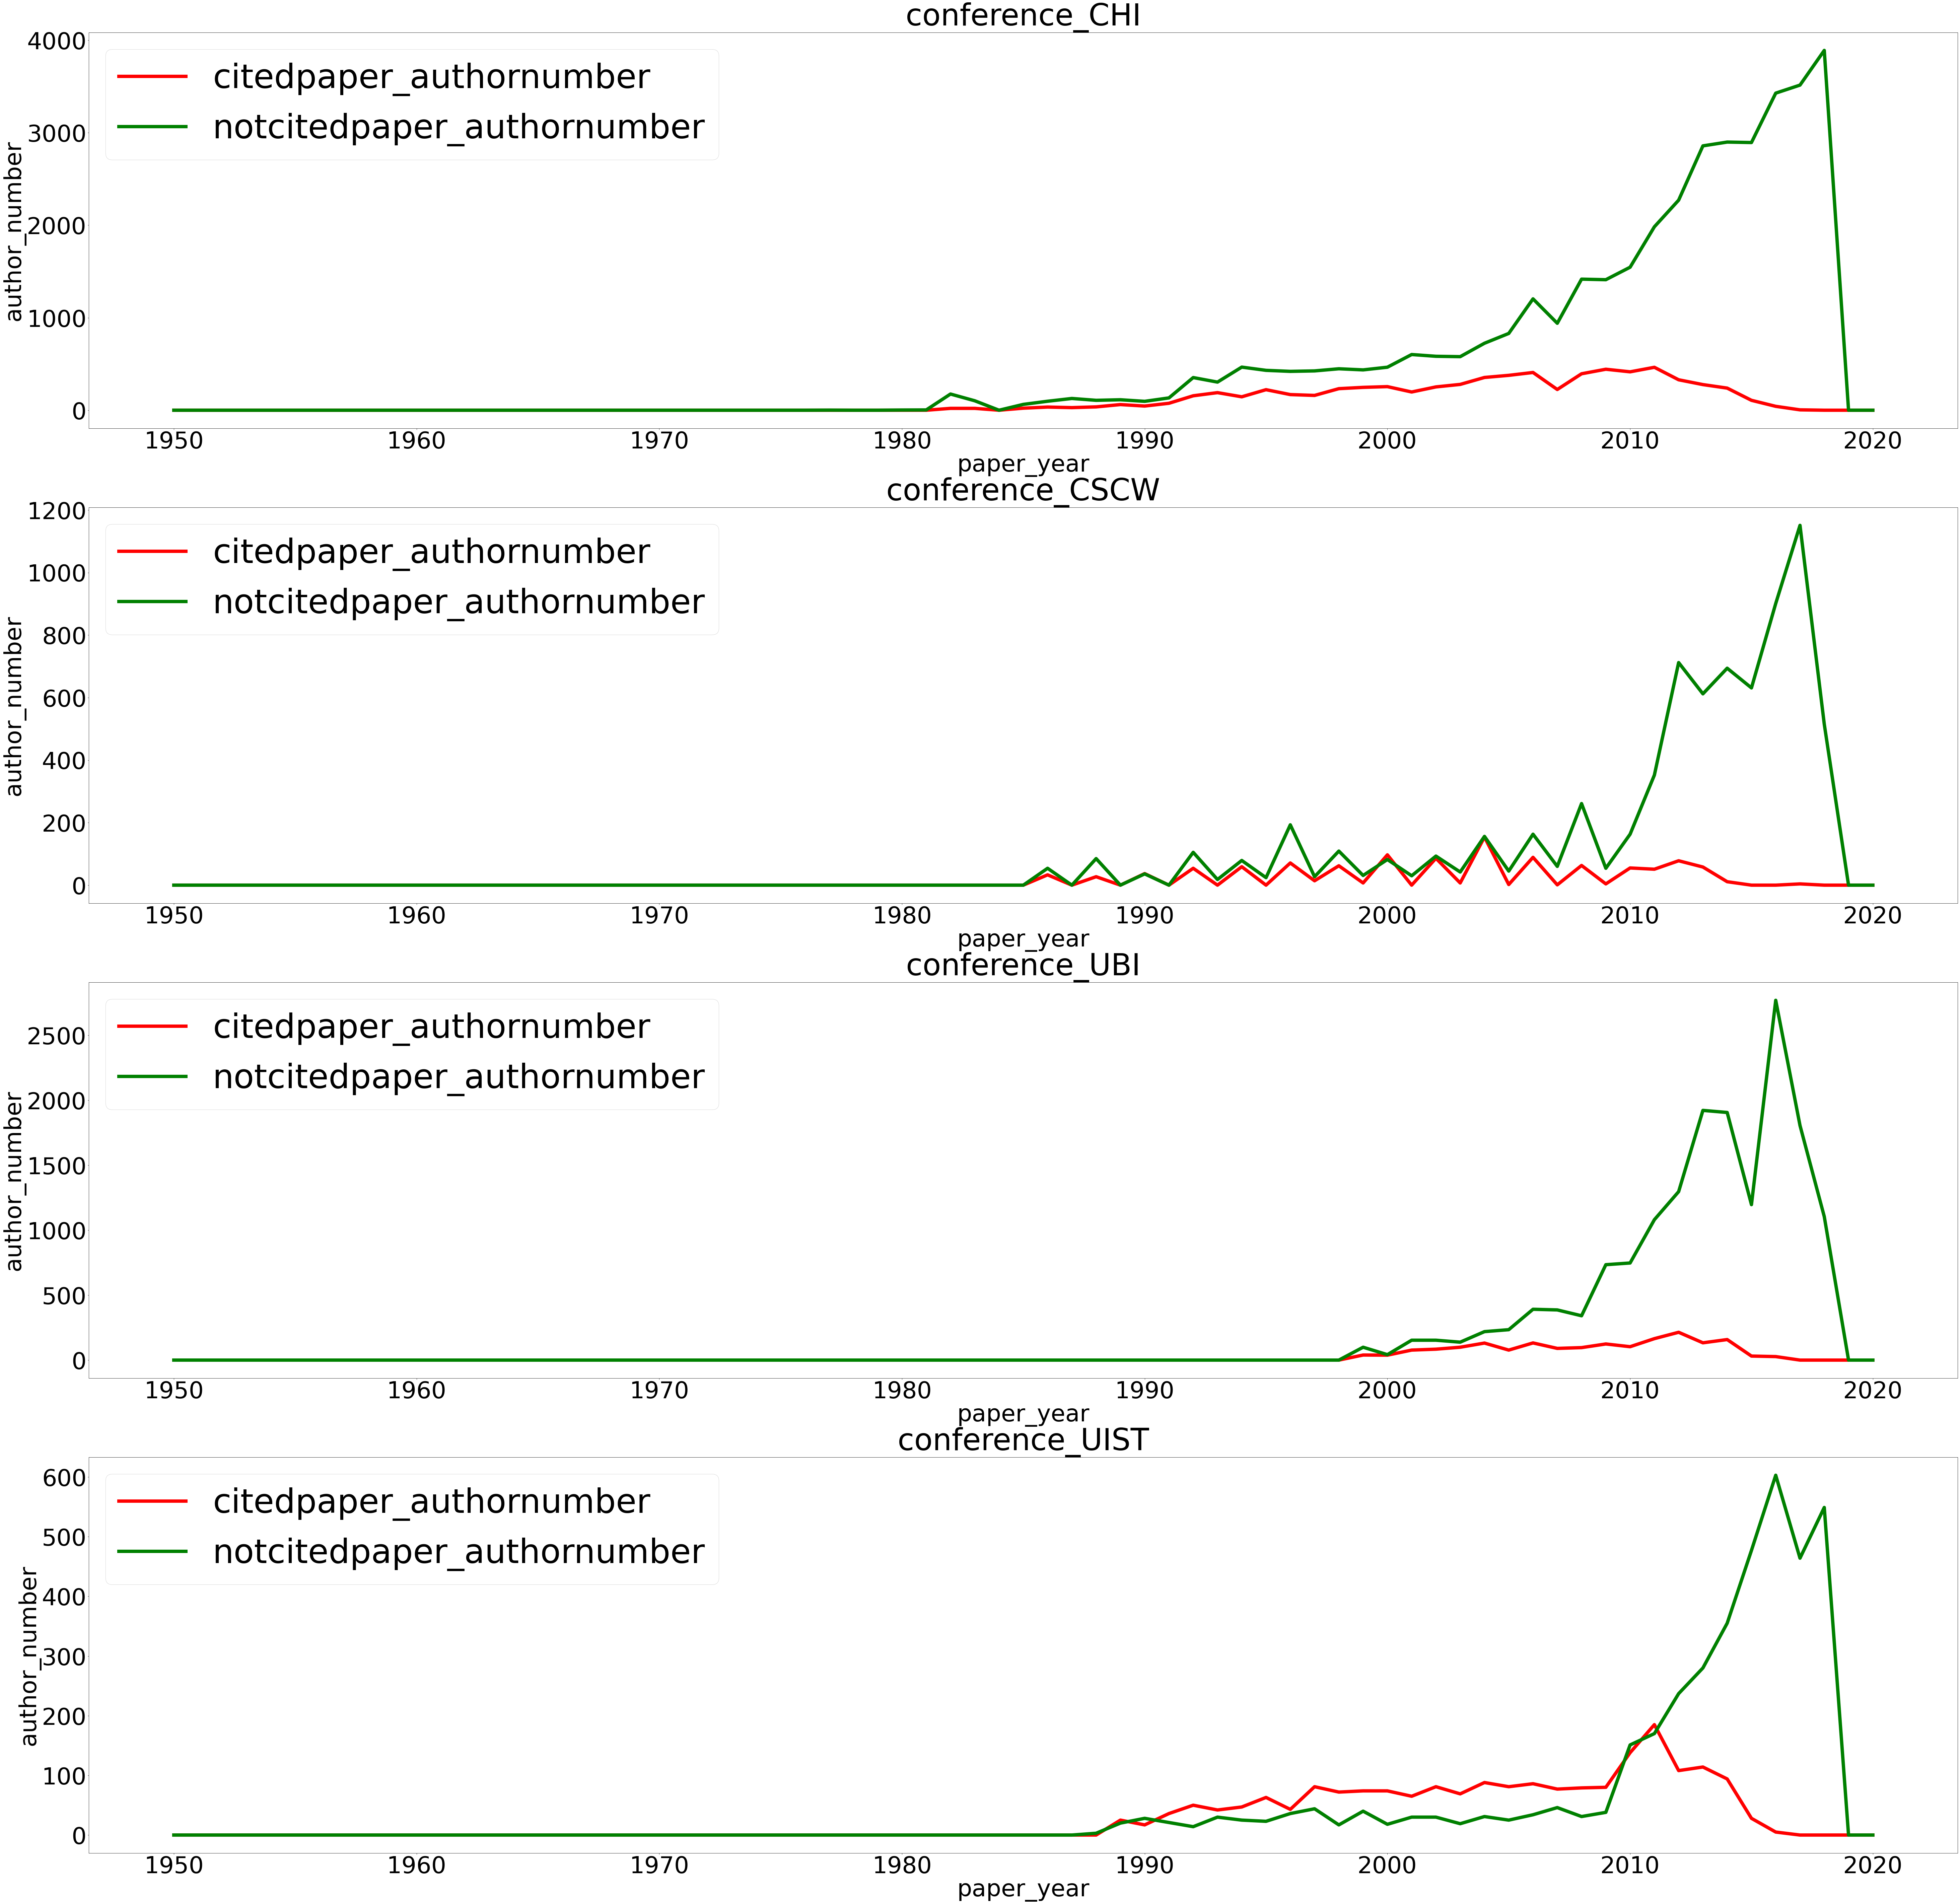

In [19]:
# Visualization
fig = plt.figure(figsize=(100,100))
axes = fig.subplots(nrows=4)

for ax_c in axes:
    ax_c.set_xlabel("paper_year", fontsize=70)
    ax_c.set_ylabel("author_number", fontsize=70)
    ax_c.tick_params(labelsize=70)

plot_idx = 0

X_year = [i for i in range (1950, 2021)]

for conf, paperyear_map in paperyear_map_conf.items():
    Y_citedpaper_authorcnt = [0] * 71
    Y_notcitedpaper_authorcnt = [0] * 71

    cited_author_map = cited_author_map_conf[conf]
    notcited_author_map = notcited_author_map_conf[conf]
    for i in range (1950, 2021):
        if str(i) in cited_author_map.keys():
            Y_citedpaper_authorcnt[i-1950] = len(cited_author_map[str(i)])    
        if str(i) in notcited_author_map.keys():
            Y_notcitedpaper_authorcnt[i-1950] = len(notcited_author_map[str(i)])    

    axes[plot_idx].plot(X_year,Y_citedpaper_authorcnt, 'o-', label='citedpaper_authornumber', color='r', linewidth = 10)
    axes[plot_idx].legend(loc = 'upper left', prop={'size': 100})
    axes[plot_idx].plot(X_year,Y_notcitedpaper_authorcnt, 'o-', label='notcitedpaper_authornumber', color='g', linewidth = 10)
    axes[plot_idx].set_title('conference_{}'.format(conf), fontsize=90)
    axes[plot_idx].legend(loc = 'upper left', prop={'size': 100})
    plot_idx += 1

In [20]:
#------------ analyze paper point -------------#
ori_citingpaper_conf = {}

df_cited = pd.read_csv('../data/papercited.tsv', usecols=[1,2])
df_paper_cited = df_cited.merge(df_paperid, left_on='citedpaperid', right_on='paperid')
# citing paper
for conf_name,conf_id in conf_key.items():
    ori_citingpaper_conf[conf_name] = df_paper_cited.loc[df_paper_cited['confid']==conf_id]
ori_citingpaper_conf['CHI'].head(5)

citingpaperid  citedpaperid     paperid      confid
0          25464    2134332471  2134332471  1163450153
1        4666531    2134332471  2134332471  1163450153
2       16009414    2134332471  2134332471  1163450153
3       17770477    2134332471  2134332471  1163450153
4       18161553    2134332471  2134332471  1163450153

In [21]:
citingpaper_map_conf = {}
for conf, df in ori_citingpaper_conf.items():
    citingpaper_map = {}
    inv_paperyear_map = inv_paperyear_map_conf[conf]
    for row in df.iterrows():
        citing_paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1]
        cited_paperid = str(row[1]).split(',')[0].split('\n')[1].split()[1]
        # paperyear
        paperyear = inv_paperyear_map[cited_paperid]
        if paperyear not in citingpaper_map.keys():
            citingpaper_map[paperyear] = []
        citingpaper_map[paperyear].append(citing_paperid)
    citingpaper_map_conf[conf] = citingpaper_map
print(">>> citing paper map construction done")

>>> citing paper map construction done


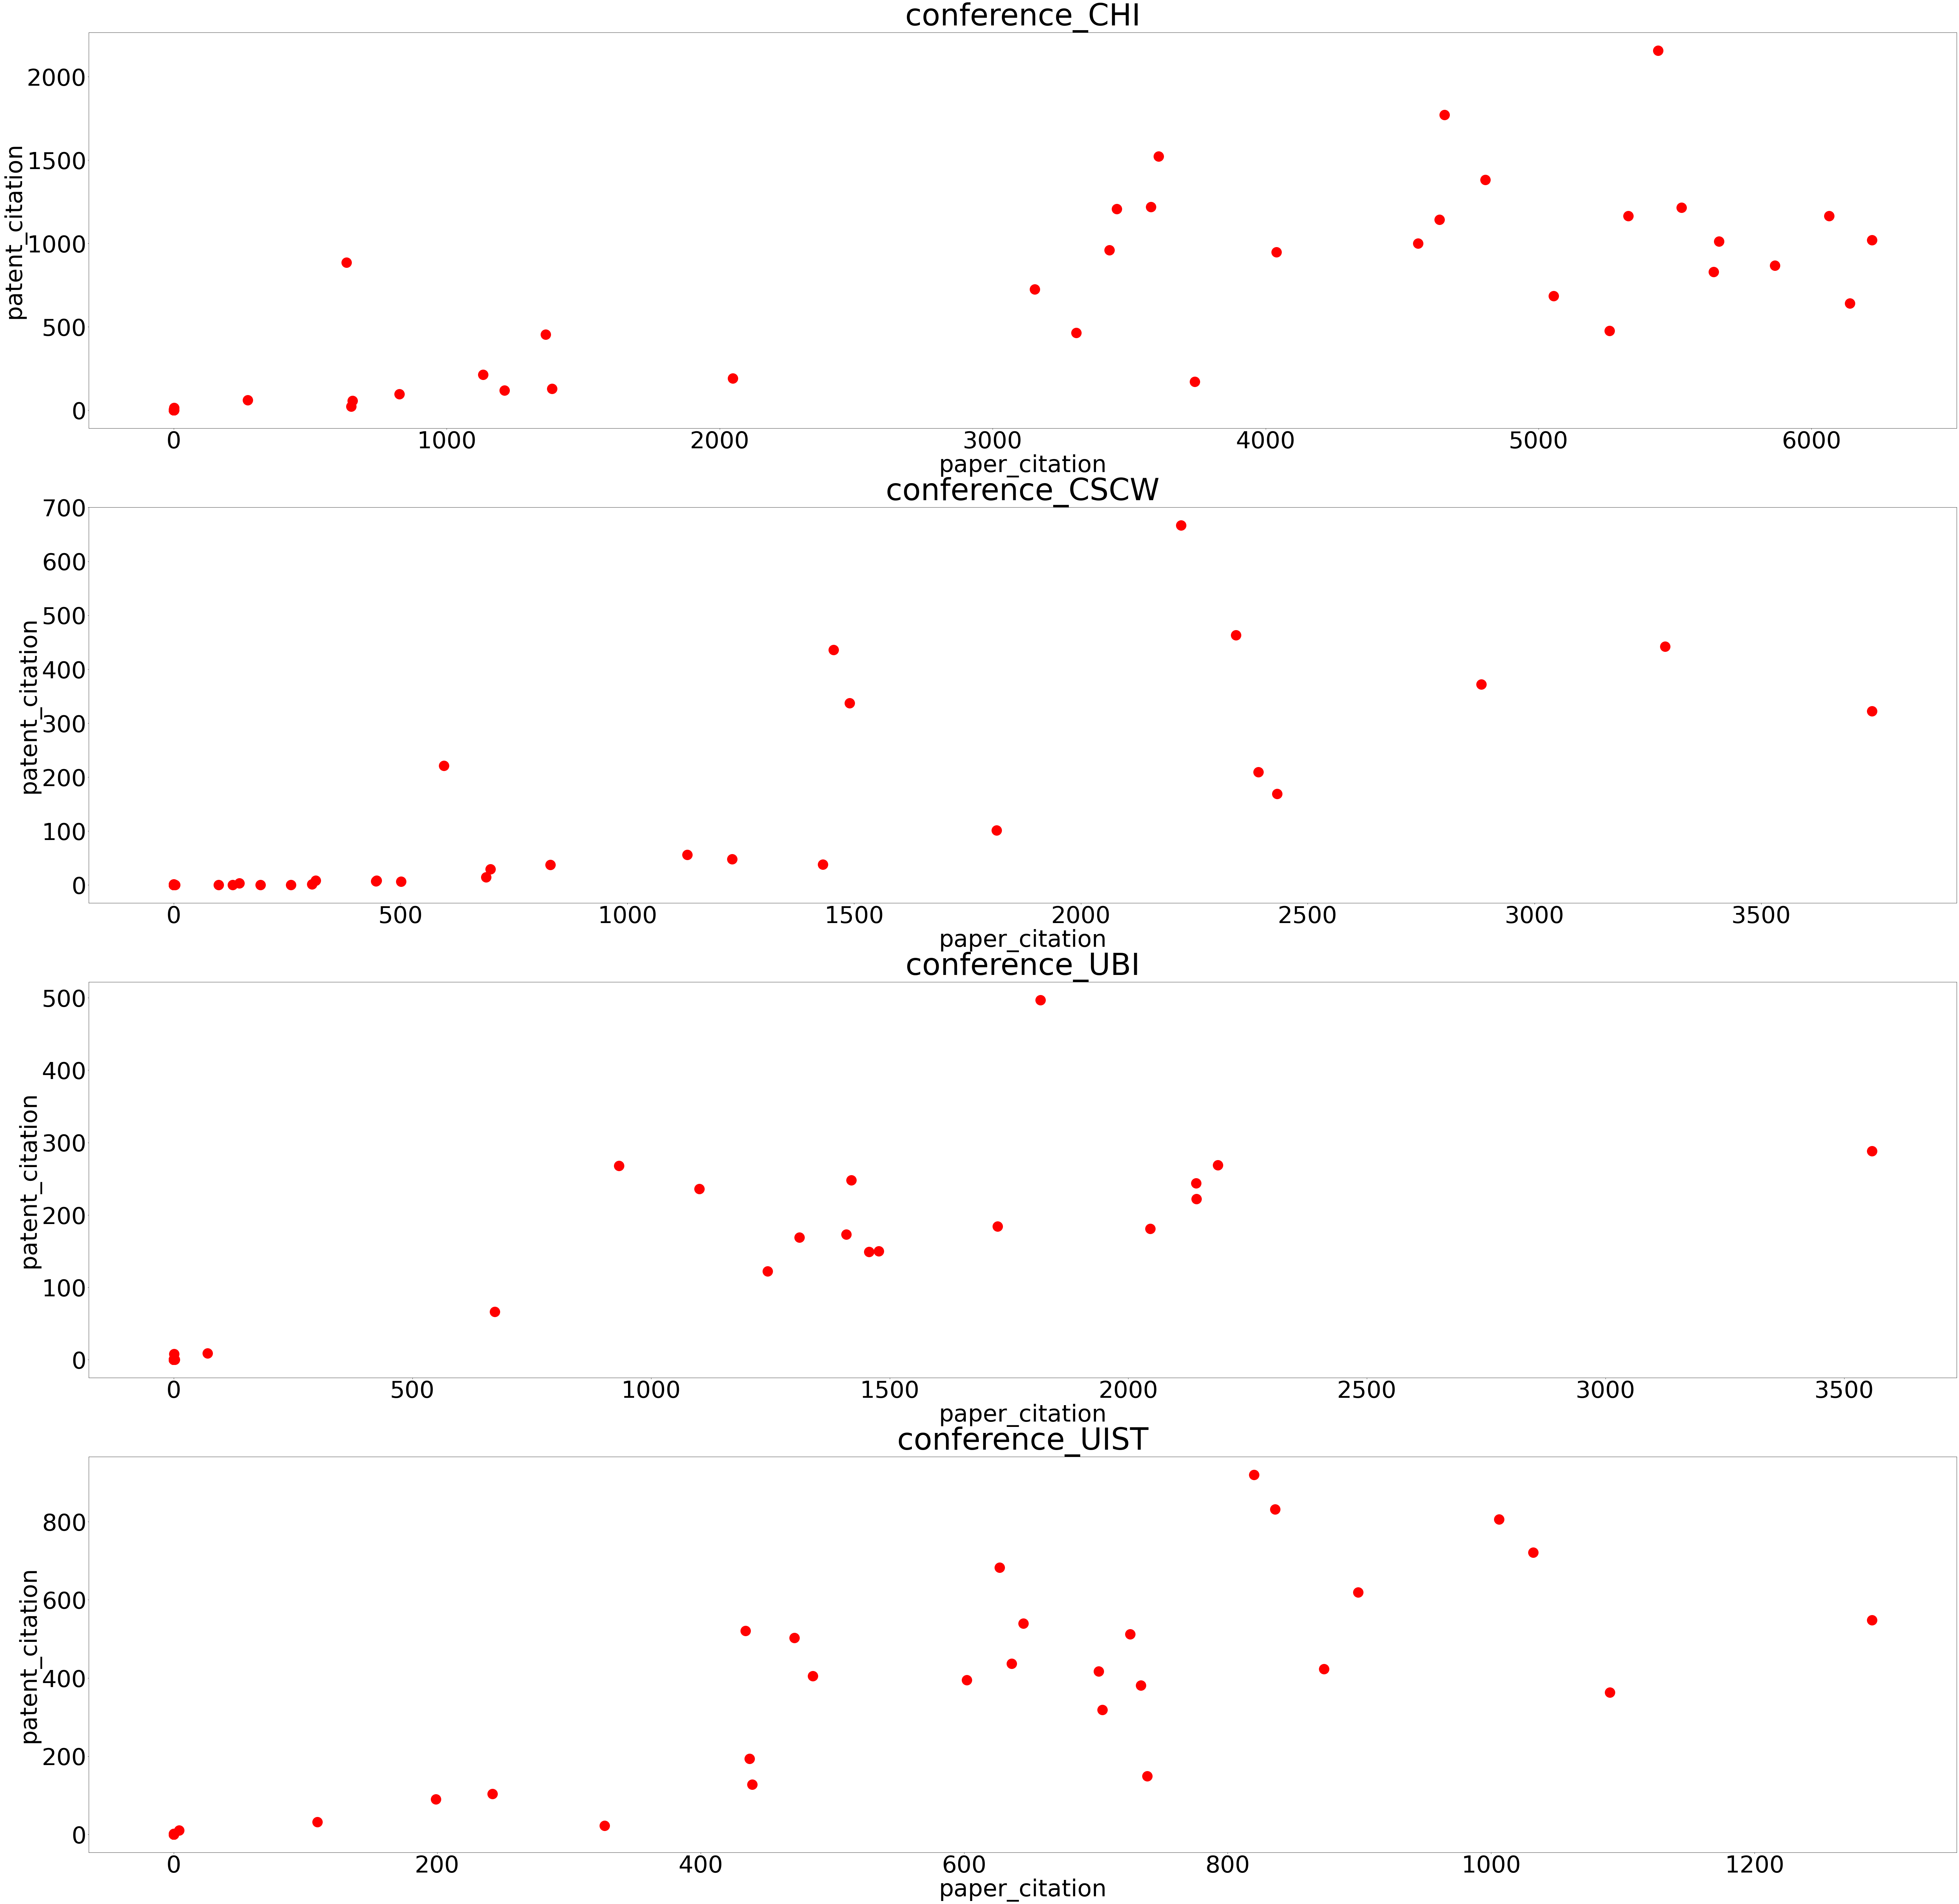

In [25]:
# point visualization
fig = plt.figure(figsize=(100,100))
axes = fig.subplots(nrows=4)

for ax_c in axes:
    ax_c.set_xlabel("paper_citation", fontsize=70)
    ax_c.set_ylabel("patent_citation", fontsize=70)
    ax_c.tick_params(labelsize=70)

plot_idx = 0

X_year = [i for i in range (1950, 2021)]

for conf, paperyear_map in paperyear_map_conf.items():
    Y_citingpatentcnt = [0] * 71
    Y_citingpapercnt = [0] * 71

    citingpatent_map = citingpatent_map_conf[conf]
    citingpaper_map = citingpaper_map_conf[conf]
    for i in range (1950, 2021):
        if str(i) in citingpatent_map.keys():
            Y_citingpatentcnt[i-1950] = len(citingpatent_map[str(i)])    
        if str(i) in citingpaper_map.keys():
            Y_citingpapercnt[i-1950] = len(citingpaper_map[str(i)])

    axes[plot_idx].plot(Y_citingpapercnt,Y_citingpatentcnt,'o',color='r',markersize=30)
    axes[plot_idx].set_title('conference_{}'.format(conf), fontsize=90)
    plot_idx += 1


In [24]:
#------------ analyze VIS4 -------------#
cited_citingpaper_map_conf = {}
notcited_citingpaper_map_conf = {}

cited_paper_map_conf = {}
notcited_paper_map_conf = {}

for conf, df in ori_citingpaper_conf.items():
    cited_citingpaper_map = {}
    notcited_citingpaper_map = {}
    cited_paper_map = {}
    notcited_paper_map = {}
    cited_paper_list = citedpaper_list_conf[conf]
    inv_paperyear_map = inv_paperyear_map_conf[conf]
    for row in df.iterrows():
        citing_paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1]
        cited_paperid = str(row[1]).split(',')[0].split('\n')[1].split()[1]
        # paperyear
        paperyear = inv_paperyear_map[cited_paperid]
        if cited_paperid in cited_paper_list:
            if paperyear not in cited_citingpaper_map.keys():
                cited_citingpaper_map[paperyear] = []
            if paperyear not in cited_paper_map.keys():
                cited_paper_map[paperyear] = {}
            if cited_paperid not in cited_paper_map[paperyear].keys():
                cited_paper_map[paperyear][cited_paperid] = []
            if citing_paperid not in cited_paper_map[paperyear][cited_paperid]:
                cited_paper_map[paperyear][cited_paperid].append(citing_paperid)
            # if citing_paperid not in cited_citingpaper_map[paperyear]:
            cited_citingpaper_map[paperyear].append(citing_paperid)
        else:
            if paperyear not in notcited_citingpaper_map.keys():
                notcited_citingpaper_map[paperyear] = []
            if paperyear not in notcited_paper_map.keys():
                notcited_paper_map[paperyear] = {}
            if cited_paperid not in notcited_paper_map[paperyear].keys():
                notcited_paper_map[paperyear][cited_paperid] = []
            if citing_paperid not in notcited_paper_map[paperyear][cited_paperid]:
                notcited_paper_map[paperyear][cited_paperid].append(citing_paperid)
            # if citing_paperid not in notcited_citingpaper_map[paperyear]:
            notcited_citingpaper_map[paperyear].append(citing_paperid)
    cited_citingpaper_map_conf[conf] = cited_citingpaper_map
    notcited_citingpaper_map_conf[conf] = notcited_citingpaper_map
    cited_paper_map_conf[conf] = cited_paper_map
    notcited_paper_map_conf[conf] = notcited_paper_map
print(">>> cited paper map construction done")

>>> cited paper map construction done


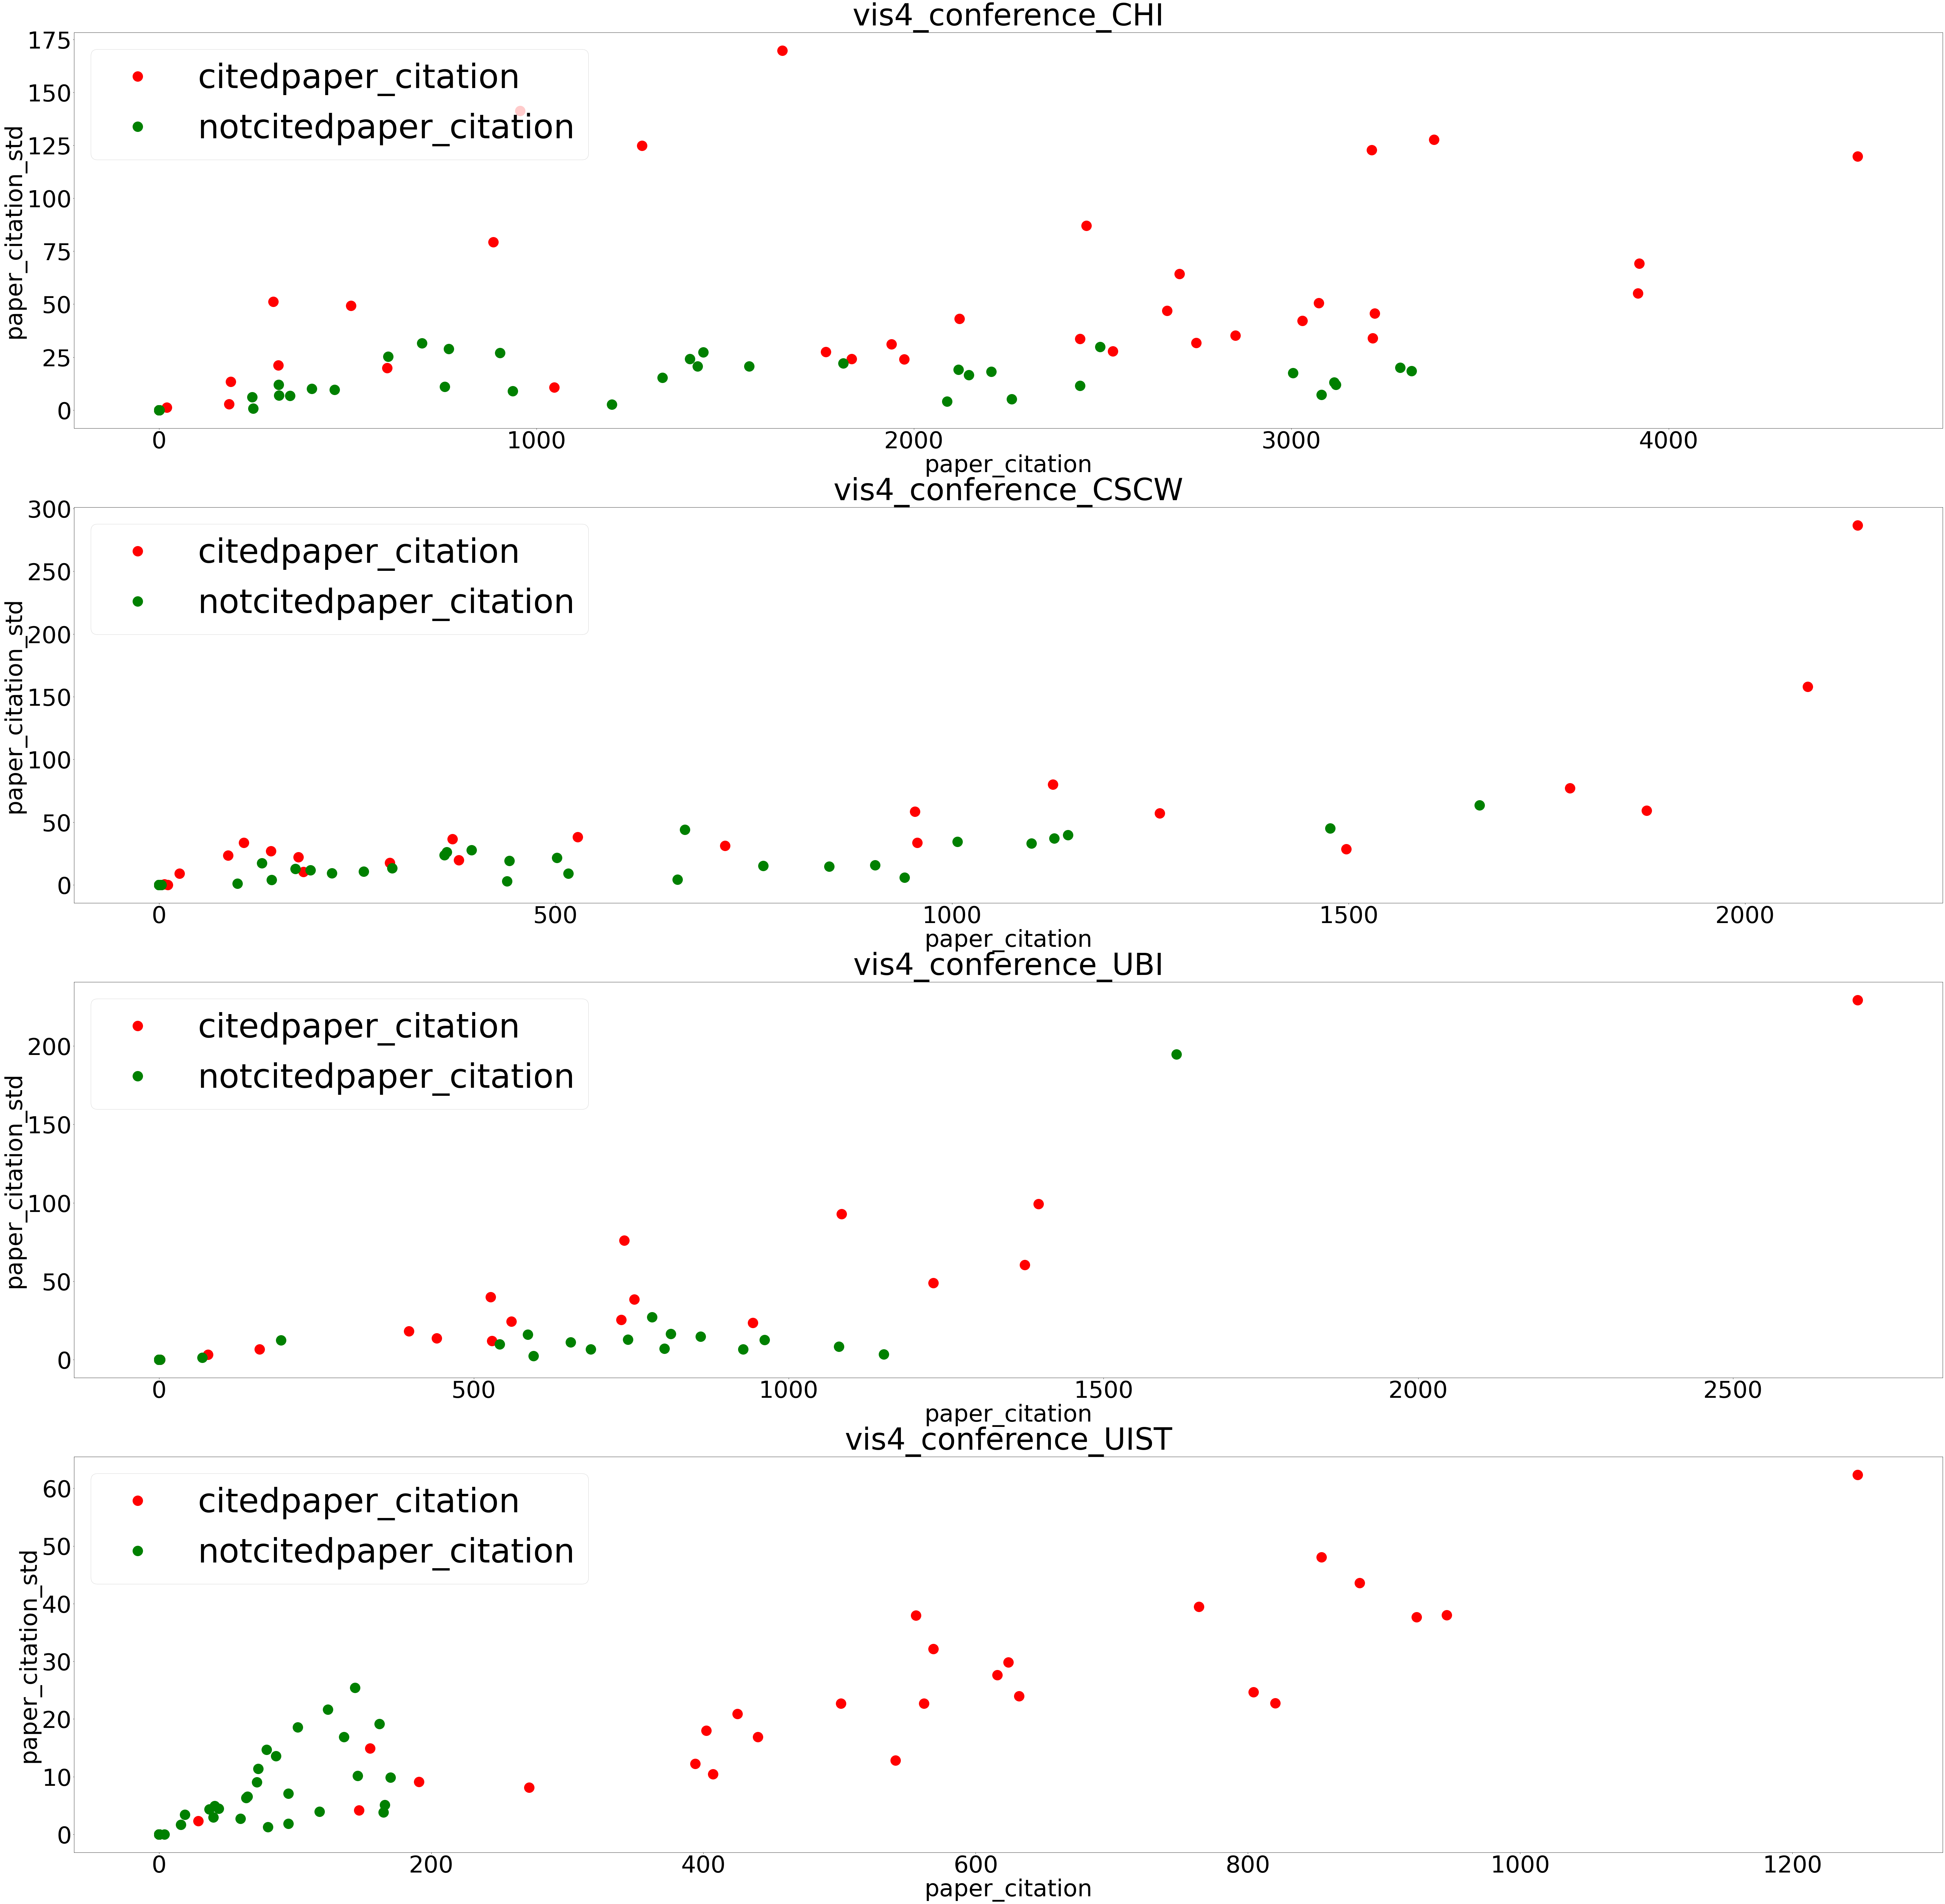

In [26]:
# visualization
X_year = [i for i in range (1950, 2021)]
fig = plt.figure(figsize=(100,100))
axes = fig.subplots(nrows=4)

for ax_c in axes:
    ax_c.set_xlabel("paper_citation", fontsize=70)
    ax_c.set_ylabel("paper_citation_std", fontsize=70)
    ax_c.tick_params(labelsize=70)

plot_idx = 0
for conf, paperyear_map in paperyear_map_conf.items():
    Y_citedpaper_citation_std = [0.0] * 71
    Y_notcitedpaper_citation_std = [0.0] * 71
    Y_citedpaper_citation_cnt= [0] * 71
    Y_notcitedpaper_citation_cnt = [0] * 71
    cited_totalcitation = 0
    notcited_totalcitation = 0

    cited_citingpaper_map = cited_citingpaper_map_conf[conf]
    notcited_citingpaper_map = notcited_citingpaper_map_conf[conf]
    cited_paper_map = cited_paper_map_conf[conf]
    notcited_paper_map = notcited_paper_map_conf[conf]
    for i in range (1950, 2021):
        if str(i) in cited_citingpaper_map.keys():
            Y_citedpaper_citation_cnt[i-1950] = len(cited_citingpaper_map[str(i)])
            cited_totalcitation += len(cited_citingpaper_map[str(i)])
        if str(i) in notcited_citingpaper_map.keys():
            Y_notcitedpaper_citation_cnt[i-1950] = len(notcited_citingpaper_map[str(i)])
            notcited_totalcitation += len(notcited_citingpaper_map[str(i)])

    for i in range (1950, 2021):
        if str(i) in cited_paper_map.keys():
            citing_list = []
            for key,val in cited_paper_map[str(i)].items():
                citing_list.append(len(val))
            # print(">>> cited conf{} list{}".format(conf, citing_list))
            Y_citedpaper_citation_std[i-1950] = np.std(citing_list)
        if str(i) in notcited_paper_map.keys():
            citing_list = []
            for key,val in notcited_paper_map[str(i)].items():
                citing_list.append(len(val))
            # print(">>> notcited conf{} list{}".format(conf, citing_list))
            Y_notcitedpaper_citation_std[i-1950] = np.std(citing_list)

    axes[plot_idx].plot(Y_citedpaper_citation_cnt,Y_citedpaper_citation_std,'o',label='citedpaper_citation',color='r',markersize=30)
    axes[plot_idx].legend(loc = 'upper left', prop={'size': 100})
    axes[plot_idx].plot(Y_notcitedpaper_citation_cnt,Y_notcitedpaper_citation_std,'o',label='notcitedpaper_citation',color='g',markersize=30)
    axes[plot_idx].legend(loc = 'upper left', prop={'size': 100})
    axes[plot_idx].set_title('vis4_conference_{}'.format(conf), fontsize=90)
    plot_idx += 1

In [27]:
single_citingpaper_map_conf = {}
for conf, df in ori_citingpaper_conf.items():
    single_citingpaper_map = {}
    for row in df.iterrows():
        citing_paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1]
        cited_paperid = str(row[1]).split(',')[0].split('\n')[1].split()[1]
        if cited_paperid not in single_citingpaper_map.keys():
            single_citingpaper_map[cited_paperid] = []
        single_citingpaper_map[cited_paperid].append(citing_paperid)
    single_citingpaper_map_conf[conf] = single_citingpaper_map
print(">>> single citing paper map construction done")

>>> single citing paper map construction done


In [30]:
single_citingpatent_map_conf = {}
for conf, df in ori_citingpatent_conf.items():
    single_citingpatent_map = {}
    for row in df.iterrows():
        paperid = str(row[1]).split(',')[0].split('\n')[0].split()[1] # paperid
        patentid = str(row[1]).split(',')[0].split('\n')[1].split()[1] # patentid

        if paperid not in single_citingpatent_map.keys():
            single_citingpatent_map[paperid] = []
        single_citingpatent_map[paperid].append(patentid)

    single_citingpatent_map_conf[conf] = single_citingpatent_map
print(">>> done single citing data")

>>> done single citing data


NameError: name 'single_citingpatent_map_conf' is not defined

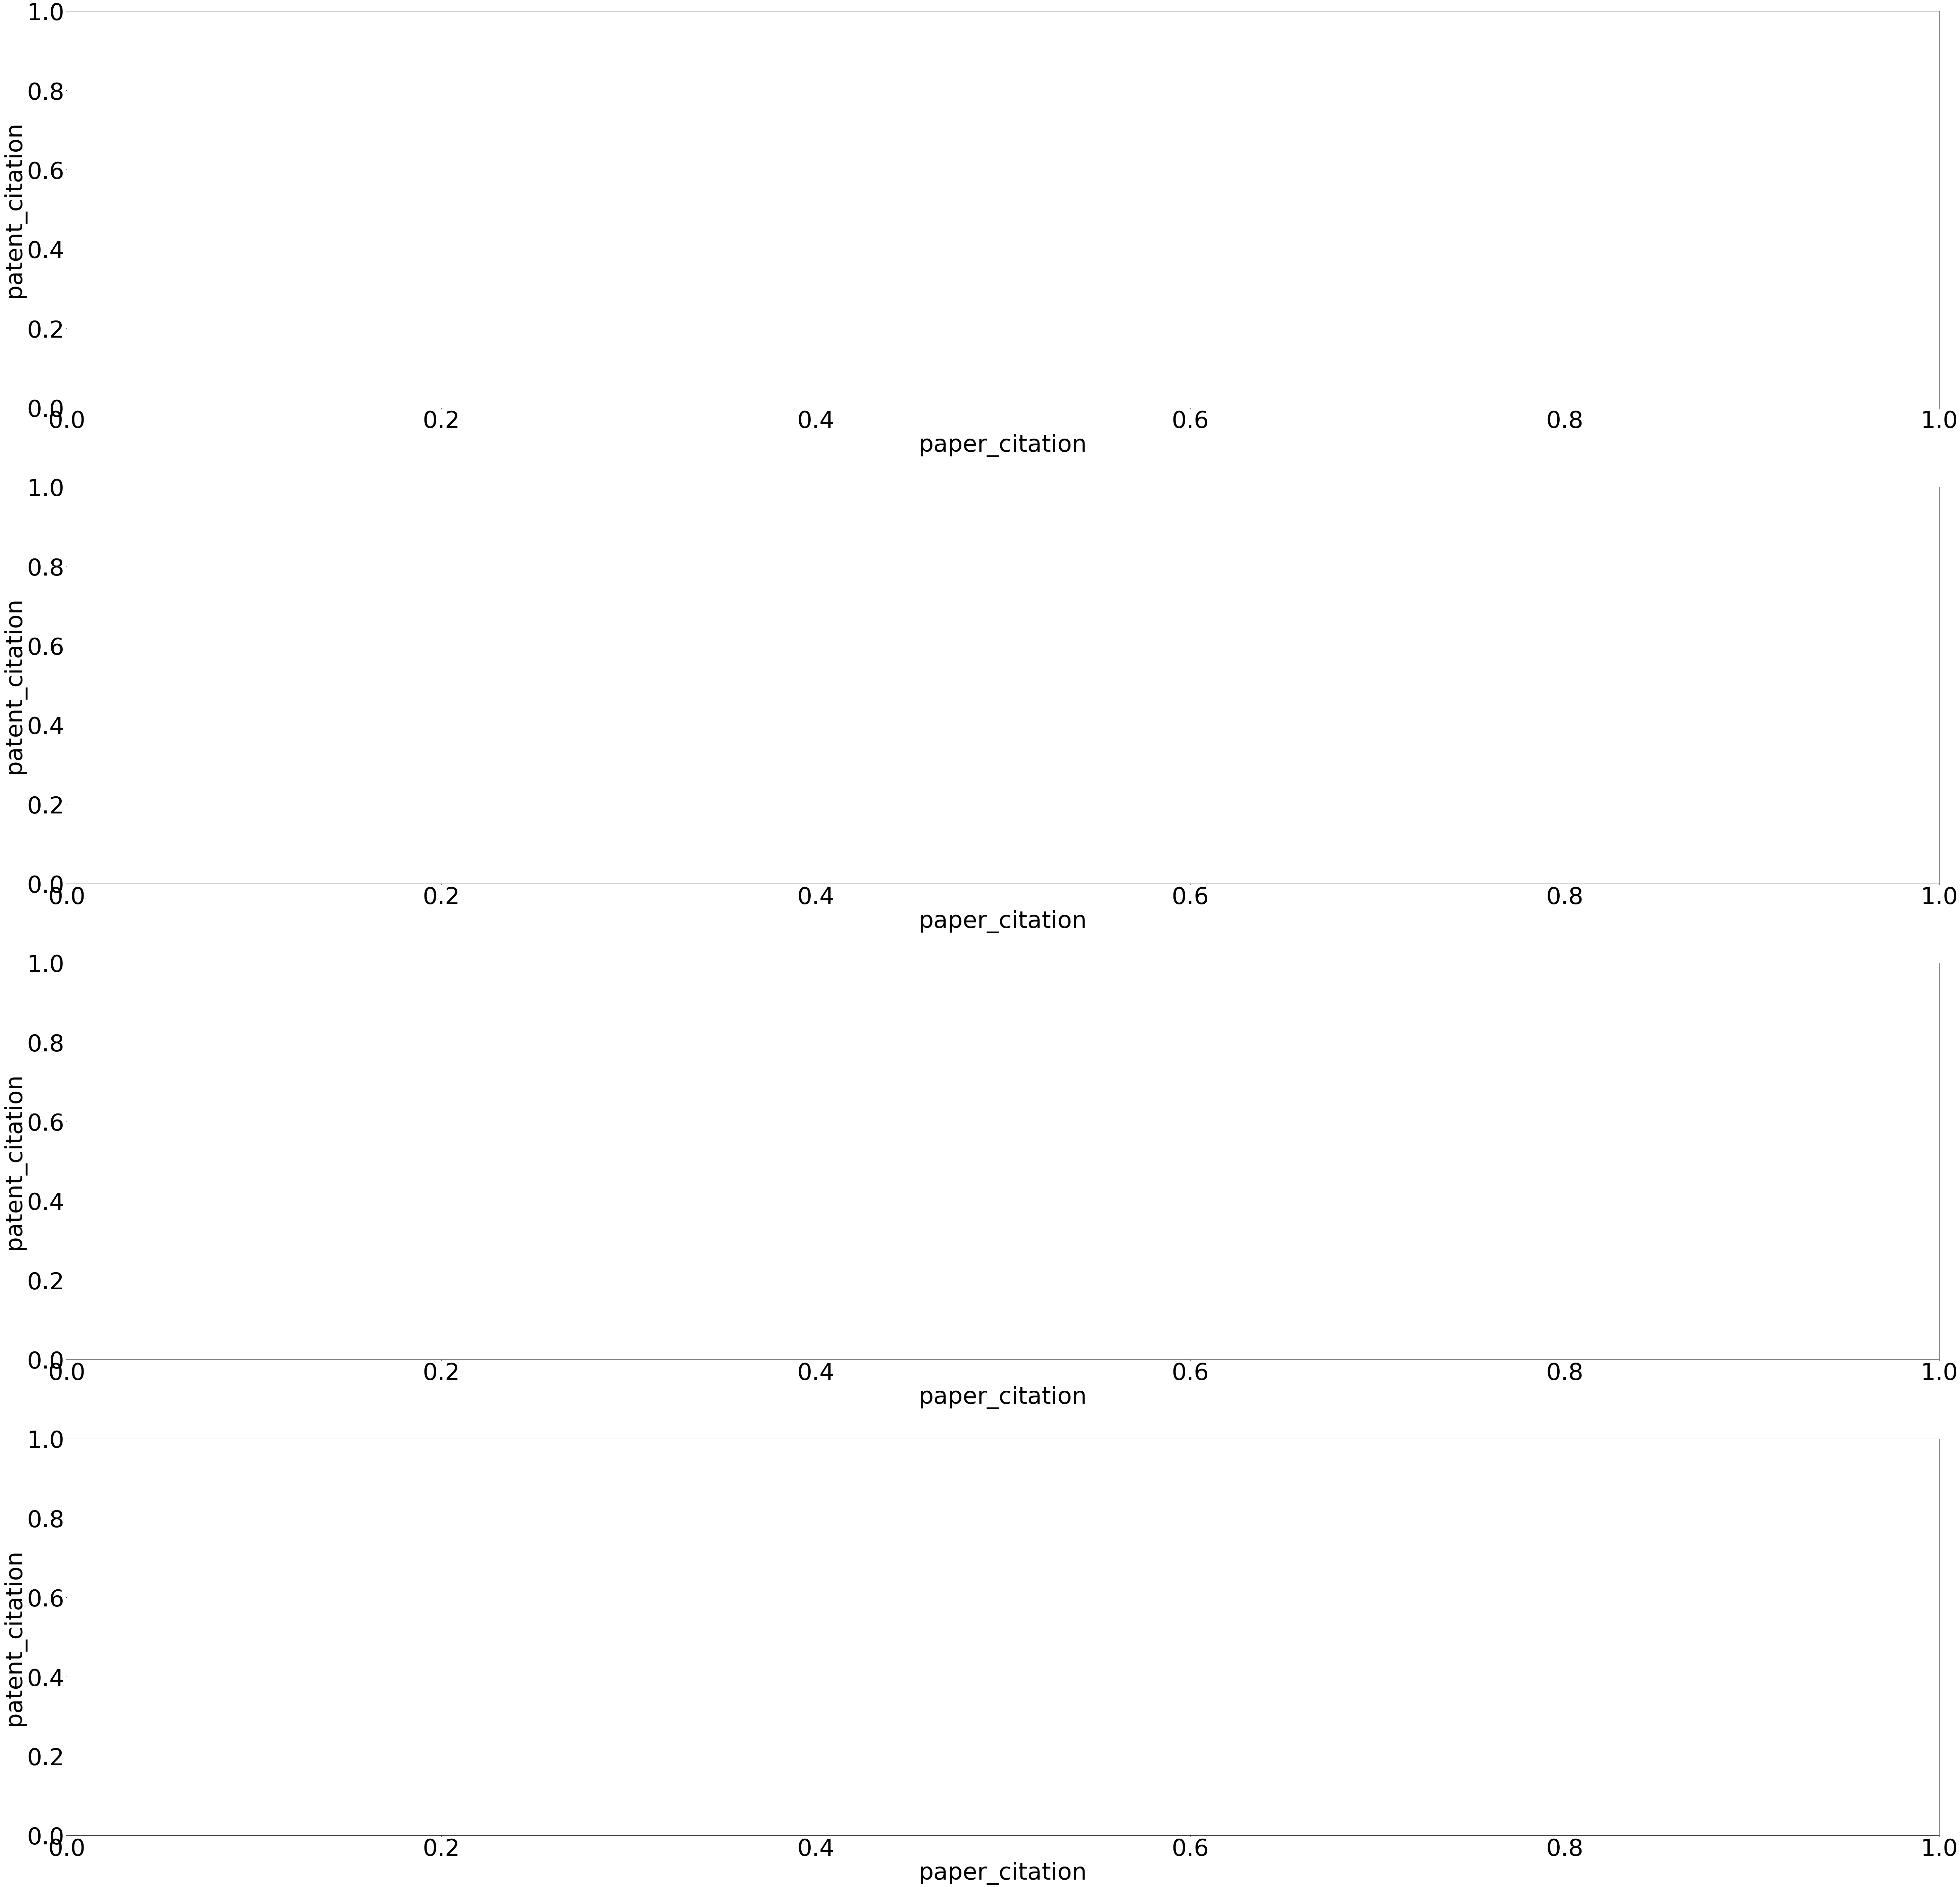

In [29]:
# single point visualization
fig = plt.figure(figsize=(100,100))
axes = fig.subplots(nrows=4)

for ax_c in axes:
    ax_c.set_xlabel("paper_citation", fontsize=70)
    ax_c.set_ylabel("patent_citation", fontsize=70)
    ax_c.tick_params(labelsize=70)

plot_idx = 0

for conf, paperyear_map in paperyear_map_conf.items():
    citingpatent_map = single_citingpatent_map_conf[conf]
    citingpaper_map = single_citingpaper_map_conf[conf]
    Y_citingpatentcnt = [0] * max(len(citingpatent_map), len(citingpaper_map))
    Y_citingpapercnt = [0] * max(len(citingpatent_map), len(citingpaper_map))
    idx = 0
    for key, val in citingpatent_map.items():
        Y_citingpatentcnt[idx] = len(val)
        if key in citingpaper_map:
            Y_citingpapercnt[idx] = len(citingpaper_map[key])
        else:
             Y_citingpapercnt[idx] = 0
        idx += 1
    axes[plot_idx].plot(Y_citingpapercnt,Y_citingpatentcnt,'o',color='r',markersize=30)
    axes[plot_idx].set_title('conference_{}'.format(conf), fontsize=90)
    plot_idx += 1


In [ ]:
import seaborn as sns


In [ ]:
#------------ analyze popular transferred paper -------------#
CHI_pd = pd.read_csv("papercitations_CHI.tsv", sep=',')
CSCW_pd = pd.read_csv("papercitations_CSCW.tsv", sep=',')
UIST_pd = pd.read_csv("papercitations_UIST.tsv", sep=',')
UBI_pd = pd.read_csv("papercitations_UBI.tsv", sep=',')

CHI_pcs_pd = pd.read_csv("../papercitation2science_extracted/papercitationscience_result_CHI.tsv", sep=',')
CSCW_pcs_pd = pd.read_csv("../papercitation2science_extracted/papercitationscience_result_CSCW.tsv", sep=',')
UIST_pcs_pd = pd.read_csv("../papercitation2science_extracted/papercitationscience_result_UIST.tsv", sep=',')
UBI_pcs_pd = pd.read_csv("../papercitation2science_extracted/papercitationscience_result_UBI.tsv", sep=',')
pcs_pd_list = [CHI_pcs_pd, CSCW_pcs_pd, UIST_pcs_pd, UBI_pcs_pd]
pd_list = [CHI_pd, CSCW_pd, UIST_pd, UBI_pd]

for idx in range(4):
    citation_pd = pd_list[idx]
    cited_paper_num = {}
    cited_patent_num = {}
    for row in citation_pd.iterrows():
        citing_paperid_str = str(row).split()[5] # paperid
        cited_paperid_str = str(row).split()[7]
        if cited_paperid_str in cited_paper_num.keys():
            cited_paper_num[cited_paperid_str] += 1
        else:
            cited_paper_num[cited_paperid_str] = 1
    result = []
    paperid_list = []
    # print(cited_paper_num)
    pcs_pd = pcs_pd_list[idx]
    for row in pcs_pd.iterrows():
        paperid = str(row).split()[9]
        patentid = str(row).split()[11]
        paperid_list.append(paperid)
        if paperid in cited_patent_num.keys():
            cited_patent_num[paperid] += 1
        else:
            cited_patent_num[paperid] = 1
    for k, v in cited_paper_num.items():
        if k not in cited_patent_num.keys():
            cited_patent_num[k] = 0                
        result.append(list([k, str(cited_paper_num[k]), str(cited_patent_num[k])]))
    result_pd = pd.DataFrame(data=result, columns=['paperid', 'citedbypapers', 'citedbypatents'])
    result_pd.to_csv('popular_transferred_paper{}.tsv'.format(idx))